In [1]:
import os
import cv2

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("alzheimer_train_valid.csv")
test_df = pd.read_csv("alzheimer_benchmark.csv")

In [3]:
train_df, valid_df = train_test_split(train, test_size=0.2, stratify=train['class'], random_state=42)

In [4]:
print("     Train set size:", len(train_df))
print("Validation set size:", len(valid_df))
print("      Test set size:", len(test_df))

     Train set size: 10175
Validation set size: 2544
      Test set size: 600


In [5]:
print("\nTrain set class distribution:")
print(train_df['class'].value_counts())

print("\nValidation set class distribution:")
print(valid_df['class'].value_counts())

print("\nTest set class distribution:")
print(test_df['class'].value_counts())


Train set class distribution:
class
Very_Mild_Demented    2952
Mild_Demented         2515
Non_Demented          2440
Moderate_Demented     2268
Name: count, dtype: int64

Validation set class distribution:
class
Very_Mild_Demented    738
Mild_Demented         629
Non_Demented          610
Moderate_Demented     567
Name: count, dtype: int64

Test set class distribution:
class
Non_Demented          150
Very_Mild_Demented    150
Moderate_Demented     150
Mild_Demented         150
Name: count, dtype: int64


In [6]:
def extract_rgb_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (130, 130))
    return image.flatten()

In [7]:
train_features = [extract_rgb_features(image_path) for image_path in train_df['image_path']]
train_features = np.array(train_features)

valid_features = [extract_rgb_features(image_path) for image_path in valid_df['image_path']]
valid_features = np.array(valid_features)

test_features = [extract_rgb_features(image_path) for image_path in test_df['image_path']]
test_features = np.array(test_features)

In [8]:
print("     Train features shape:", train_features.shape)
print("Validation features shape:", valid_features.shape)
print("      Test features shape:", test_features.shape)

# 128 * 128 * 3 = 49152

     Train features shape: (10175, 50700)
Validation features shape: (2544, 50700)
      Test features shape: (600, 50700)


# Gradient Boosting

In [9]:
clf = GradientBoostingClassifier(random_state=42)

In [10]:
clf.fit(train_features, train_df['class'])

GradientBoostingClassifier(random_state=42)

In [11]:
predictions = clf.predict(test_features)
predictions

array(['Non_Demented', 'Non_Demented', 'Moderate_Demented',
       'Moderate_Demented', 'Moderate_Demented', 'Mild_Demented',
       'Non_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented',
       'Moderate_Demented', 'Non_Demented', 'Non_Demented',
       'Moderate_Demented', 'Very_Mild_Demented', 'Moderate_Demented',
       'Moderate_Demented', 'Mild_Demented', 'Mild_Demented',
       'Moderate_Demented', 'Very_Mild_Demented', 'Moderate_Demented',
       'Mild_Demented', 'Moderate_Demented', 'Non_Demented',
       'Moderate_Demented', 'Mild_Demented', 'Non_Demented',
       'Mild_Demented', 'Mild_Demented', 'Moderate_Demented',
       'Non_Demented', 'Non_Demented', 'Mild_Demented',
       'Moderate_Demented', 'Very_Mild_Demented', 'Moderate_Demented',
       'Mild_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented',
       'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented',
       'Non_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented',
       'Moderate_Demented'

In [12]:
pred_proba = clf.predict_proba(test_features)

In [13]:
confusion_mat = confusion_matrix(test_df['class'], predictions)
unique_classes = np.unique(test_df['class'])
confusion_df = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

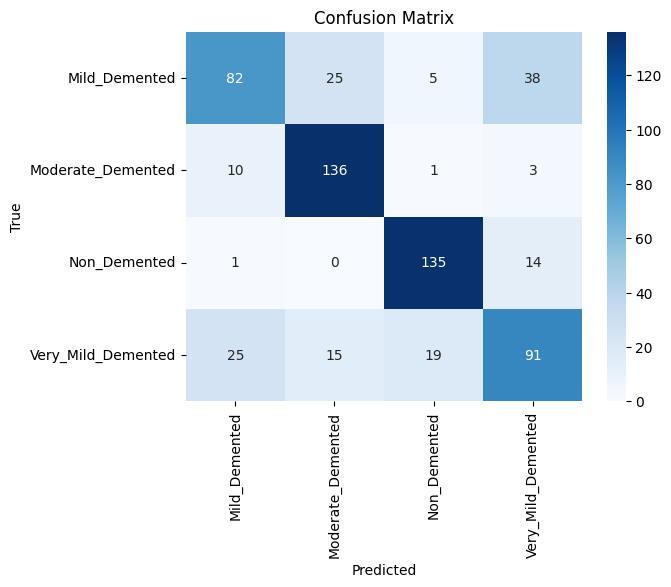

Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.69      0.55      0.61       150
 Moderate_Demented       0.77      0.91      0.83       150
      Non_Demented       0.84      0.90      0.87       150
Very_Mild_Demented       0.62      0.61      0.61       150

          accuracy                           0.74       600
         macro avg       0.73      0.74      0.73       600
      weighted avg       0.73      0.74      0.73       600



In [14]:

sns.heatmap(confusion_df, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(test_df['class'], predictions)
print("Classification Report:\n", class_report)

In [15]:
class_names = unique_classes

In [16]:
predicted_classes = []
confidence_scores = []

for index, row in test_df.iterrows():
    image_path = row['image_path']
    image_features = extract_rgb_features(image_path)
    image_features = np.array(image_features).reshape(1, -1)
    decision_distances = clf.predict_proba(image_features)
    confidence_scores.append(decision_distances)
    predicted_class_index = np.argmax(decision_distances)
    predicted_class = class_names[predicted_class_index]
    predicted_classes.append(predicted_class)

In [17]:
reshaped_scores = np.array([arr[0] for arr in confidence_scores])
confidence_df = pd.DataFrame(reshaped_scores, columns=unique_classes)

In [18]:
confidence_df

,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented
0,0.031567,0.007692,0.848973,0.111768
1,0.033526,0.013735,0.775795,0.176944
2,0.235327,0.411673,0.007729,0.345271
3,0.255517,0.435542,0.009088,0.299853
4,0.229712,0.578879,0.009660,0.181749
...,...,...,...,...
595,0.349016,0.048521,0.057245,0.545218
596,0.250308,0.037281,0.250075,0.462336
597,0.320043,0.602750,0.003041,0.074166
598,0.169119,0.752651,0.003742,0.074488


In [19]:
test_df['predicted_class'] = predicted_classes
data_df = pd.concat([test_df, confidence_df], axis=1)
data_df

,image_path,class,predicted_class,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented
0,Benchmark\Non_Demented\non_871.jpg,Non_Demented,Non_Demented,0.031567,0.007692,0.848973,0.111768
1,Benchmark\Non_Demented\non_3104.jpg,Non_Demented,Non_Demented,0.033526,0.013735,0.775795,0.176944
2,Benchmark\Very_Mild_Demented\augmented_80_very...,Very_Mild_Demented,Moderate_Demented,0.235327,0.411673,0.007729,0.345271
3,Benchmark\Very_Mild_Demented\augmented_123_ver...,Very_Mild_Demented,Moderate_Demented,0.255517,0.435542,0.009088,0.299853
4,Benchmark\Moderate_Demented\augmented_182_mode...,Moderate_Demented,Moderate_Demented,0.229712,0.578879,0.009660,0.181749
...,...,...,...,...,...,...,...
595,Benchmark\Mild_Demented\mild_46.jpg,Mild_Demented,Very_Mild_Demented,0.349016,0.048521,0.057245,0.545218
596,Benchmark\Mild_Demented\mild_748.jpg,Mild_Demented,Very_Mild_Demented,0.250308,0.037281,0.250075,0.462336
597,Benchmark\Mild_Demented\augmented_32_mild_319.jpg,Mild_Demented,Moderate_Demented,0.320043,0.602750,0.003041,0.074166
598,Benchmark\Moderate_Demented\augmented_240_mode...,Moderate_Demented,Moderate_Demented,0.169119,0.752651,0.003742,0.074488


In [20]:
data_df.to_csv('results_confidence/gb_confidence.csv', index = False)